In [21]:
# from zeno_client import ZenoClient, ZenoMetric
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.cm import get_cmap
sys.path.append('/home/jhsia2/ragged')
from file_utils import load_json

root_dir = os.getenv('DBQA')
results_dir = os.path.join(root_dir, 'reader_results')
noisy_results_dir = os.path.join(root_dir, 'noisy_reader_results')


cmap = plt.colormaps['tab10']  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list


1. Load all the dataframes in 1a. If it doesn't exist, run 1b.

2. Plot the figures. You can customize dataset, reader_metric, slice, reader_models, retriever_models...etc.

    2a. Plot all instances

    2b. Plot gold/no gold par found

    2c. Plot baselines (gold, no-context)

    2d. Plot by question category

    2e. Plot by context precision

# 1a. Load dataframes

In [79]:
import pickle
import os
reader_models = ['flanUl2', 'llama_70b', 'flanT5', 'llama_7b', 'llama_70b_2000_truncation', 'llama_7b_2000_truncation']
# retriever_models = ['gold','colbert', 'bm25']
retriever_models = ['colbert','gold']
top_ks= ["baseline", "top1", "top2", "top3", "top5", "top10", "top20", "top30", "top50"]

with open(os.path.join(os.getenv('DBQA'), 'combined_zeno.pkl'), 'rb') as f:
    output_by_dataset = pickle.load(f)

with open(os.path.join(os.getenv('DBQA'), 'noisy_combined_zeno.pkl'), 'rb') as f:
    noisy_output_by_dataset = pickle.load(f)

# 1a. Create and save dataframe compilation

In [19]:
def get_precision(guess_wiki_id_set, gold_wiki_id_set):
    precision = np.mean([[s in gold_wiki_id_set] for s in guess_wiki_id_set])
    return precision
def get_recall(guess_wiki_id_set, gold_wiki_id_set):
    recall = np.mean([[s in guess_wiki_id_set] for s in gold_wiki_id_set]) if len(gold_wiki_id_set) > 0 else 0.0
    return recall

def combine_gold_and_compiled(output_data, gold_data, questions_categorized, is_bioasq = False):
    if is_bioasq:
        docid_key = 'pmid'
        docid_name = 'pm'
        section_key = 'section'
        section_name = 'sec'
    else:
        docid_key = 'wikipedia_id'
        docid_name = 'wiki'
        section_key = 'start_paragraph_id'
        section_name = 'par'
    
    for i, (od, gd) in enumerate(zip(output_data, gold_data)):
        if(od['id'] != gd['id']):
            print(od, gd)
            break
        # od['dataset'] = gd['dataset']
        od['question_category'] = questions_categorized[od['id']]
        od['gold_answer_set'] = gd['output']['answer_set']
        od[f'gold_{docid_name}_id_set'] = gd['output'][f'{docid_name}_id_set']
        od[f'gold_{docid_name}_{section_name}_id_set'] = gd['output'][f'{docid_name}_{section_name}_id_set']
        od['gold_title_set'] = gd['output']['title_set']
    return output_data
def get_reader_df(top_k, combined_data, is_bioasq = False):
    if is_bioasq:
        docid_key = 'pmid'
        docid_name = 'pm'
        section_key = 'section'
        section_name = 'sec'
    else:
        docid_key = 'wikipedia_id'
        docid_name = 'wiki'
        section_key = 'start_paragraph_id'
        section_name = 'par'
    return pd.DataFrame(
        {
            "question": [d['input'] for d in combined_data],
            # "dataset": [d['dataset'] for d in combined_data],
            "question_category": [d['question_category'] for d in combined_data],
            "id": [d['id'] for d in combined_data],
            "output": [
                # json.dumps(
                    {   
                        "gold answer set": ', '.join(d['gold_answer_set']),
                        "answer": d["output"]["answer"],
                    }
                # )
                for d in combined_data
            ],
            
            f"gold {docid_name}_{section_name}_id set size": [
                len(d[f"gold_{docid_name}_{section_name}_id_set"]) for d in combined_data
            ],
            "f1": [
                d["output"]["answer_evaluation"]["f1"] for d in combined_data
            ],
            "exact_match": [
                d["output"]["answer_evaluation"]["exact_match"] for d in combined_data
            ],
            "substring_match": [
                d["output"]["answer_evaluation"]["substring_match"] for d in combined_data
            ],
            "answer_in_context": [
                d["output"]["summary context evaluation"]["answer_in_context"] for d in combined_data
            ],
            f"any {docid_name}_id_match": [False for d in combined_data] if top_k == 'baseline' else [
                d["output"]["summary context evaluation"][f"{docid_name}_id_match"] for d in combined_data
            ],
            f"any {docid_name}_{section_name}_id_match": [False for d in combined_data] if top_k == 'baseline' else [
                d["output"]["summary context evaluation"][f"{docid_name}_{section_name}_id_match"] for d in combined_data
            ],
            f"precision {docid_name}_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_precision(set([r.get(f"{docid_name}_id", None) for r in d["output"]["retrieved"]]), d[f'gold_{docid_name}_id_set']) for d in combined_data
            ],
            f"precision {docid_name}_{section_name}_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_precision(set([r.get(f"{docid_name}_{section_name}_id", None) for r in d["output"]["retrieved"]]), d[f'gold_{docid_name}_{section_name}_id_set']) for d in combined_data
            ],
            f"recall {docid_name}_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_recall(set([r.get(f"{docid_name}_id", None) for r in d["output"]["retrieved"]]), d[f'gold_{docid_name}_id_set']) for d in combined_data
            ],
            f"recall {docid_name}_{section_name}_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_recall(set([r.get(f"{docid_name}_{section_name}_id", None) for r in d["output"]["retrieved"]]), d[f'gold_{docid_name}_{section_name}_id_set']) for d in combined_data
            ],
        }
    )

In [13]:
output_by_dataset = {}
for dataset in ['nq', 'complete_bioasq']:
    if 'bioasq' in dataset:
        docid_key = 'pmid'
        docid_name = 'pm'
        section_key = 'section'
        section_name = 'sec'
    else:
        docid_key = 'wikipedia_id'
        docid_name = 'wiki'
        section_key = 'start_paragraph_id'
        section_name = 'par'

    id2title = load_json(os.path.join(root_dir, f'data/corpus_files/{docid_name}_{section_name}_id2title.json'))

    gold_data = load_json(os.path.join(root_dir, 'data/gold_zeno_files', f"gold_{dataset}_zeno_file.json"), sort_by_id = True)

    questions_categorized = load_json(os.path.join(root_dir, f'data/questions_categorized/{dataset}_questions_categorized.json'))

    output_by_dataset[dataset] = {}

    reader_models = ['flanUl2', 'llama_70b', 'flanT5', 'llama_7b', 'llama_70b_2000_truncation', 'llama_7b_2000_truncation']
    reader_models = ['flanUl2', 'llama_70b', 'flanT5', 'llama_7b', 'llama_70b_2000_truncation']
    retriever_models = ['colbert','gold']
    top_ks= ["baseline", "top1", "top2", "top3", "top5", "top10", "top20", "top30", "top50"]
    print(retriever_models)
    print(reader_models)
    print(top_ks)
    output_dfs = {}
    for retriever_model in retriever_models:
        for reader_model in reader_models:
            if output_dfs.get(reader_model, None) == None:
                output_dfs[reader_model] = {}
                
        
            print('retriever', retriever_model)
            print('reader', reader_model)
            if retriever_model == 'gold':

                data = load_json(os.path.join(results_dir, reader_model, dataset, 'gold', "reader_results_zeno.json"))
                        
                combined_data = combine_gold_and_compiled(data, gold_data, questions_categorized,'bioasq' in dataset)
                output_df = get_reader_df('gold', combined_data, 'bioasq' in dataset)
                output_dfs[reader_model]['gold'] = output_df
            else:
                for top_k in top_ks:
                    print(top_k)
                    data = load_json(os.path.join(results_dir, reader_model, dataset, retriever_model, f"{top_k}/reader_results_zeno.json"))
                            
                    combined_data = combine_gold_and_compiled(data, gold_data, questions_categorized,'bioasq' in dataset)
                    output_df = get_reader_df(top_k, combined_data, 'bioasq' in dataset)
                    if output_dfs[reader_model].get(retriever_model, None) == None:
                        output_dfs[reader_model][retriever_model] = {}
                    if top_k == 'baseline':
                        output_dfs[reader_model]['no_context'] = output_df
                    else:
                        output_dfs[reader_model][retriever_model][top_k] = output_df
        output_by_dataset[dataset]= output_dfs


loading from /data/tir/projects/tir6/general/afreens/dbqa/data/corpus_files/wiki_par_id2title.json
loading from /data/tir/projects/tir6/general/afreens/dbqa/data/gold_zeno_files/gold_nq_zeno_file.json
loading from /data/tir/projects/tir6/general/afreens/dbqa/data/questions_categorized/nq_questions_categorized.json
['colbert', 'gold']
['flanUl2', 'llama_70b', 'flanT5', 'llama_7b', 'llama_70b_2000_truncation']
['baseline', 'top1', 'top2', 'top3', 'top5', 'top10', 'top20', 'top30', 'top50']
retriever colbert
reader flanUl2
baseline
loading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/baseline/reader_results_zeno.json
top1
loading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/top1/reader_results_zeno.json
top2
loading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/top2/reader_results_zeno.json
top3
loading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2

/home/jhsia2/miniforge-pypy3/envs/py10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jhsia2/miniforge-pypy3/envs/py10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


retriever gold
reader llama_70b
loading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/llama_70b/complete_bioasq/gold/reader_results_zeno.json
retriever gold
reader flanT5
loading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanT5/complete_bioasq/gold/reader_results_zeno.json
retriever gold
reader llama_7b
loading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/llama_7b/complete_bioasq/gold/reader_results_zeno.json
retriever gold
reader llama_70b_2000_truncation
loading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/llama_70b_2000_truncation/complete_bioasq/gold/reader_results_zeno.json


In [22]:
noisy_output_by_dataset = {}
for dataset in ['nq']:
    if 'bioasq' in dataset:
        docid_key = 'pmid'
        docid_name = 'pm'
        section_key = 'section'
        section_name = 'sec'
    else:
        docid_key = 'wikipedia_id'
        docid_name = 'wiki'
        section_key = 'start_paragraph_id'
        section_name = 'par'

    id2title = load_json(os.path.join(root_dir, f'data/corpus_files/{docid_name}_{section_name}_id2title.json'))

    gold_data = load_json(os.path.join(root_dir, 'data/gold_zeno_files', f"gold_{dataset}_zeno_file.json"), sort_by_id = True)

    questions_categorized = load_json(os.path.join(root_dir, f'data/questions_categorized/{dataset}_questions_categorized.json'))

    noisy_output_by_dataset[dataset] = {}

    reader_models = ['flanUl2', 'llama_70b', 'flanT5', 'llama_7b']
    retriever_models = ['colbert']
    top_ks= ["top1", "top2", "top3", "top5", "top10", "top20", "top30", "top50"]
    print(retriever_models)
    print(reader_models)
    print(top_ks)
    output_dfs = {}
    for retriever_model in retriever_models:
        for reader_model in reader_models:
            if output_dfs.get(reader_model, None) == None:
                output_dfs[reader_model] = {}
                
        
            print('retriever', retriever_model)
            print('reader', reader_model)
            if retriever_model == 'gold':

                data = load_json(os.path.join(noisy_results_dir, reader_model, dataset, 'gold', "reader_results_zeno.json"))
                        
                combined_data = combine_gold_and_compiled(data, gold_data, questions_categorized,'bioasq' in dataset)
                output_df = get_reader_df('gold', combined_data, 'bioasq' in dataset)
                output_dfs[reader_model]['gold'] = output_df
            else:
                for top_k in top_ks:
                    print(top_k)
                    data = load_json(os.path.join(noisy_results_dir, reader_model, dataset, retriever_model, f"{top_k}/reader_results_zeno.json"))
                            
                    combined_data = combine_gold_and_compiled(data, gold_data, questions_categorized,'bioasq' in dataset)
                    output_df = get_reader_df(top_k, combined_data, 'bioasq' in dataset)
                    if output_dfs[reader_model].get(retriever_model, None) == None:
                        output_dfs[reader_model][retriever_model] = {}
                    if top_k == 'baseline':
                        output_dfs[reader_model]['no_context'] = output_df
                    else:
                        output_dfs[reader_model][retriever_model][top_k] = output_df
        noisy_output_by_dataset[dataset]= output_dfs


loading from /data/tir/projects/tir6/general/afreens/dbqa/data/corpus_files/wiki_par_id2title.json
loading from /data/tir/projects/tir6/general/afreens/dbqa/data/gold_zeno_files/gold_nq_zeno_file.json
loading from /data/tir/projects/tir6/general/afreens/dbqa/data/questions_categorized/nq_questions_categorized.json
['colbert']
['flanUl2', 'llama_70b', 'flanT5', 'llama_7b']
['top1', 'top2', 'top3', 'top5', 'top10', 'top20', 'top30', 'top50']
retriever colbert
reader flanUl2
top1
loading from /data/tir/projects/tir6/general/afreens/dbqa/noisy_reader_results/flanUl2/nq/colbert/top1/reader_results_zeno.json
top2
loading from /data/tir/projects/tir6/general/afreens/dbqa/noisy_reader_results/flanUl2/nq/colbert/top2/reader_results_zeno.json
top3
loading from /data/tir/projects/tir6/general/afreens/dbqa/noisy_reader_results/flanUl2/nq/colbert/top3/reader_results_zeno.json
top5
loading from /data/tir/projects/tir6/general/afreens/dbqa/noisy_reader_results/flanUl2/nq/colbert/top5/reader_results_z

In [23]:
import pickle
with open(os.path.join(root_dir, 'noisy_combined_zeno.pkl'), 'wb') as outp:
    pickle.dump(noisy_output_by_dataset, outp)

In [23]:
# output_by_dataset = {}
for dataset in ['nq']:
# dataset = 'complete_bioasq'
    if 'bioasq' in dataset:
        docid_key = 'pmid'
        docid_name = 'pm'
        section_key = 'section'
        section_name = 'sec'
    else:
        docid_key = 'wikipedia_id'
        docid_name = 'wiki'
        section_key = 'start_paragraph_id'
        section_name = 'par'

    id2title = load_json(os.path.join(root_dir, f'data/corpus_files/{docid_name}_{section_name}_id2title.json'))

    gold_data = load_json(os.path.join(root_dir, 'data/gold_zeno_files', f"gold_{dataset}_zeno_file.json"), sort_by_id = True)

    questions_categorized = load_json(os.path.join(root_dir, f'data/questions_categorized/{dataset}_questions_categorized.json'))

    reader_models = ['llama_7b_2000_truncation']
    retriever_models = ['colbert']
    top_ks= ["top1", "top2", "top3", "top5", "top10", "top20", "top30", "top50"]
    print(retriever_models)
    print(reader_models)
    print(top_ks)
    # output_dfs = {}
    for retriever_model in retriever_models:
        for reader_model in reader_models:
            if output_dfs.get(reader_model, None) == None:
                output_by_dataset[dataset][reader_model] = {}
                
        
            print('retriever', retriever_model)
            print('reader', reader_model)
            if retriever_model == 'gold':

                data = load_json(os.path.join(results_dir, 'llama_7b_2000_truncation_v2', dataset, 'gold', "reader_results_zeno.json"))
                        
                combined_data = combine_gold_and_compiled(data, gold_data, questions_categorized,'bioasq' in dataset)
                output_df = get_reader_df('gold', combined_data, 'bioasq' in dataset)
                output_by_dataset[dataset][reader_model]['gold'] = output_df
            else:
                for top_k in top_ks:
                    print(top_k)
                    data = load_json(os.path.join(results_dir, 'llama_7b_2000_truncation_v2', dataset, retriever_model, f"{top_k}/reader_results_zeno.json"))
                            
                    combined_data = combine_gold_and_compiled(data, gold_data, questions_categorized,'bioasq' in dataset)
                    output_df = get_reader_df(top_k, combined_data, 'bioasq' in dataset)

                    if output_by_dataset[dataset][reader_model].get(retriever_model, None) == None:
                        output_by_dataset[dataset][reader_model][retriever_model] = {}
                    if top_k == 'baseline':
                        output_by_dataset[dataset][reader_model]['no_context'] = output_df
                    else:
                        output_by_dataset[dataset][reader_model][retriever_model][top_k] = output_df

loading from /data/tir/projects/tir6/general/afreens/dbqa/data/corpus_files/wiki_par_id2title.json
loading from /data/tir/projects/tir6/general/afreens/dbqa/data/gold_zeno_files/gold_nq_zeno_file.json
loading from /data/tir/projects/tir6/general/afreens/dbqa/data/questions_categorized/nq_questions_categorized.json
['colbert']
['llama_7b_2000_truncation']
['top1', 'top2', 'top3', 'top5', 'top10', 'top20', 'top30', 'top50']
retriever colbert
reader llama_7b_2000_truncation
top1
loading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/llama_7b_2000_truncation_v2/nq/colbert/top1/reader_results_zeno.json
top2
loading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/llama_7b_2000_truncation_v2/nq/colbert/top2/reader_results_zeno.json
top3
loading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/llama_7b_2000_truncation_v2/nq/colbert/top3/reader_results_zeno.json
top5
loading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/llama

In [28]:
# import pickle
# with open(os.path.join(root_dir, 'combined_zeno.pkl'), 'wb') as outp:
#     pickle.dump(output_by_dataset, outp)

# 2a. Plot all instances 

/data/tir/projects/tir6/general/afreens/dbqa/figs/nq_colbert_f1_truncation.pdf


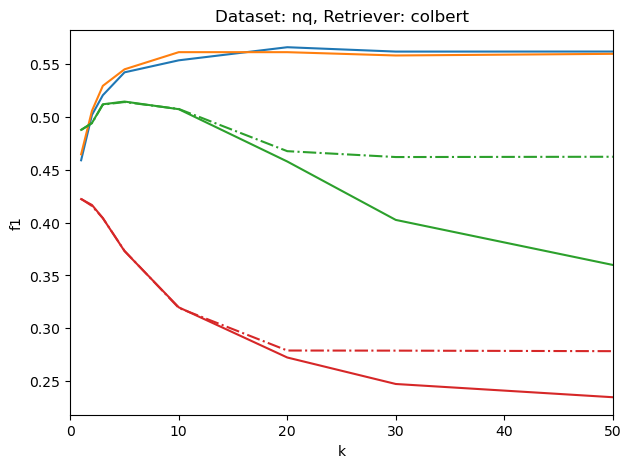

In [ ]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'nq'
reader_metric = 'f1'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    # if 'truncation' in reader_model:
    #     continue
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        k_df =output_dfs[reader_model][retriever][top_k]
        slice_df = k_df# CAN CHANGE SLICE CONDITION HERE
        reader_perf_by_k.append(np.mean(slice_df[reader_metric].values)) # CAN CHANGE READER METRIC HERE
        if '7b' in reader_model:
            color = colors[3]
        elif '70b' in reader_model:
            color = colors[2]
        else:
            color = colors[r%len(reader_models)]
        if 'truncation' in reader_model:
            linestyle = linestyles[2]
        else:
            linestyle = linestyles[0]
    
    plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = reader_model, color = color, linestyle = linestyle)

plt.title(f'Dataset: {dataset}, Retriever: {retriever}')

plt.xlabel('k')
plt.ylabel('f1')
# plt.ylim(bottom = 0.2, top = 0.6)
plt.xlim(left = 0, right = 50)
# plt.legend()
# plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
filename = os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_{retriever}_truncation_{reader_metric}.pdf')
plt.savefig(filename,bbox_inches='tight', pad_inches=0)
print(filename)
plt.show()

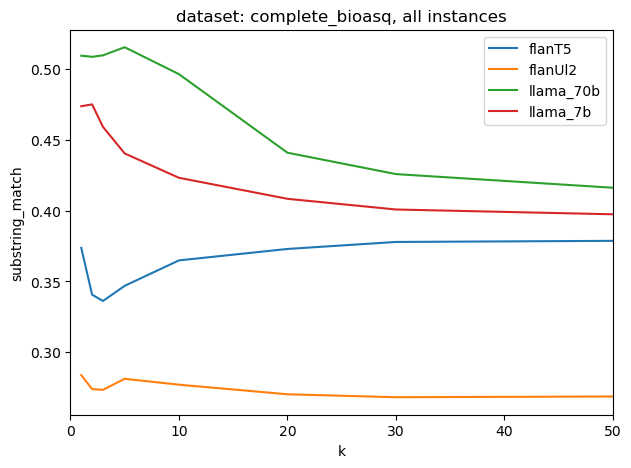

In [86]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
reader_models.sort()
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'complete_bioasq'
reader_metric = 'substring_match'

output_dfs = output_by_dataset[dataset]


for r, reader_model in enumerate(reader_models):
    if 'truncation' in reader_model:
        continue
    for r2, retriever_model in enumerate(['colbert']):
        reader_perf_by_k = []
        for i, top_k in enumerate(top_ks[1:]):
            k_df =output_dfs[reader_model][retriever_model][top_k]
            slice_df = k_df# CAN CHANGE SLICE CONDITION HERE
            reader_perf_by_k.append(np.mean(slice_df[reader_metric].values)) # CAN CHANGE READER METRIC HERE
        if '7b' in reader_model:
            color = colors[3]
        elif '70b' in reader_model:
            color = colors[2]
        else:
            color = colors[r%len(reader_models)]
        plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = f'{reader_model}', color = color, linestyle = linestyles[r2])

plt.title(f'dataset: {dataset}, all instances')

plt.xlabel('k')
plt.legend()
plt.ylabel(reader_metric)
# plt.ylim(top = 0.6, bottom = 0.2)
plt.xlim(left = 0, right = 50)
plt.savefig(os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_all_instances_{reader_metric}.pdf') , bbox_inches='tight', pad_inches=0)
plt.show()

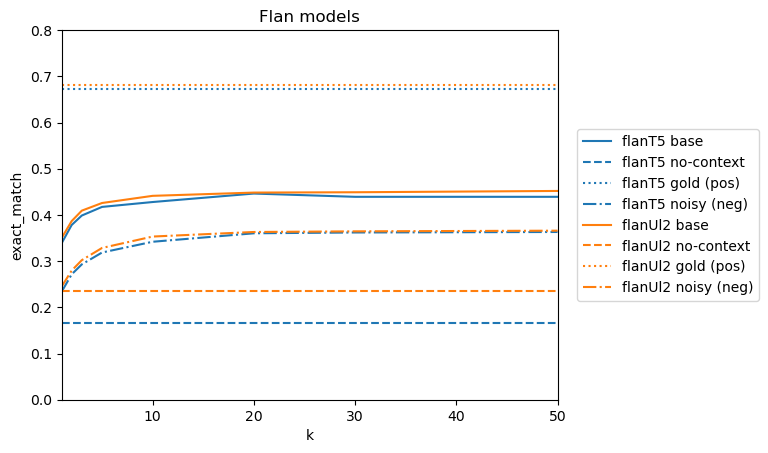

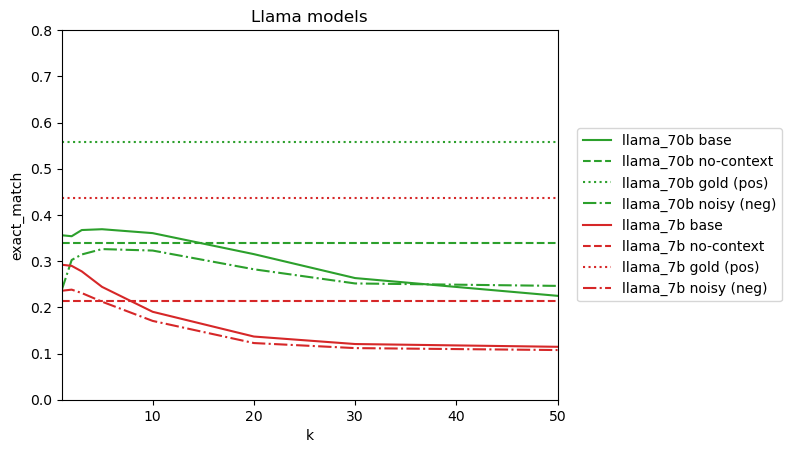

In [88]:
# for those with no gold par found, what is the baseline performance?

linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
# plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'nq'
reader_metric = 'exact_match'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
noisy_output_dfs = noisy_output_by_dataset[dataset]

readers_perf = {}
for r, reader_model in enumerate(reader_models):
    readers_perf[reader_model] = {}
    if 'truncation' in reader_model:
        continue
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        readers_perf[reader_model][top_k] = {}
        slice_df = output_dfs[reader_model][retriever][top_k]
        noisy_slice_df = noisy_output_dfs[reader_model][retriever][top_k]
        baseline_df = output_dfs[reader_model]['no_context']
        gold_df = output_dfs[reader_model]['gold']
        readers_perf[reader_model][top_k][f'noisy {reader_metric}'] = np.mean(noisy_slice_df[reader_metric].values)
        readers_perf[reader_model][top_k][reader_metric] = np.mean(slice_df[reader_metric].values)
        readers_perf[reader_model][top_k][f'baseline {reader_metric}'] = np.mean(baseline_df[reader_metric].values)
        readers_perf[reader_model][top_k][f'gold {reader_metric}'] = np.mean(gold_df[reader_metric].values)
# plt.figure(figsize = (6,4))
for i, (r, top_kdict) in enumerate(readers_perf.items()):
    if 'truncation' in r:
        continue
    top_k_f1s = []
    noisy_top_k_f1s = []
    baseline_f1s = []
    gold_f1s = []
    ks = []
    for top_k, value_dict in top_kdict.items():
        ks.append((int)(top_k[3:]))
        top_k_f1s.append(value_dict[reader_metric])
        noisy_top_k_f1s.append(value_dict[f'noisy {reader_metric}'])
        baseline_f1s.append(value_dict[f'baseline {reader_metric}'])
        gold_f1s.append(value_dict[f'gold {reader_metric}'])
    if '7b' in r:
        color = colors[3]
    elif '70b' in r:
        color = colors[2]
    else:
        color = colors[i%len(reader_models)]
        
    plt.plot(ks, top_k_f1s, color = color, label = f'{r} base')
    plt.plot(ks, baseline_f1s, color = color, linestyle = '--', label = f'{r} no-context')
    plt.plot(ks, gold_f1s, color = color, linestyle = ':', label = f'{r} gold (pos)')
    plt.plot(ks, noisy_top_k_f1s, color = color, linestyle = '-.', label = f'{r} noisy (neg)')
    
    if r == 'flanUl2':
        plt.title(f'Flan models')
        plt.legend()
        plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
        
        ytop = 0.8
        ybot = 0.0
        plt.ylim(bottom = ybot, top = ytop)
        plt.xlim(left = 1, right = 50)
        plt.xlabel('k')
        plt.ylabel(reader_metric)
        # plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_flan_pos_neg_{reader_metric}.pdf'),bbox_inches='tight', pad_inches=0)
        plt.show()
        # plt.figure(figsize = (6,4))
        
  
plt.title(f'Llama models')
plt.legend()
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.ylim(bottom = ybot, top = ytop)
plt.xlim(left = 1, right = 50)
plt.xlabel('k')
plt.ylabel(reader_metric)
# plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_llama_pos_neg_{reader_metric}.pdf'),bbox_inches='tight', pad_inches=0)
plt.show()

# 2b. Plot gold par found/no gold par found

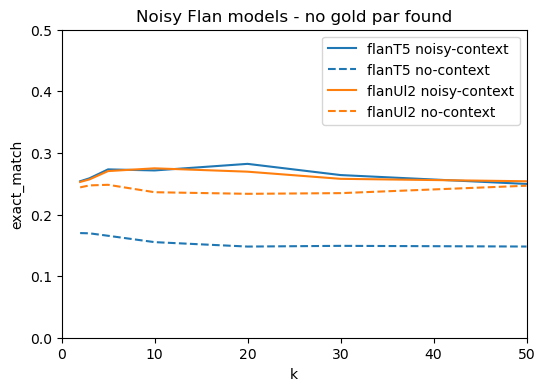

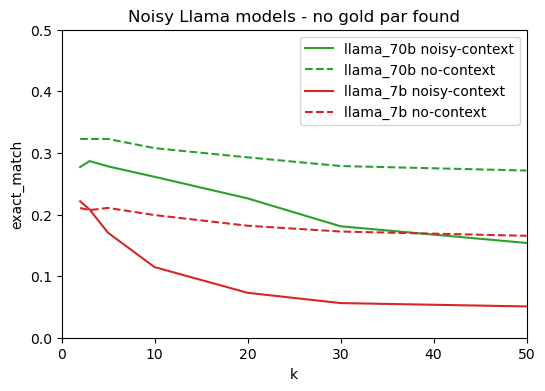

In [28]:
# for those with no gold par found, what is the baseline performance?

linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
# plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'nq'
reader_metric = 'exact_match'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]


readers_perf = {}
for r, reader_model in enumerate(reader_models):
    readers_perf[reader_model] = {}
    if 'truncation' in reader_model:
        continue
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        readers_perf[reader_model][top_k] = {}
        k_df =output_dfs[reader_model][retriever][top_k]
        slice = k_df[f'any {docid_name}_{section_name}_id_match'] == False
        # slice = k_df[f'answer_in_context'] == False
        slice_df = k_df.loc[slice]
        baseline_df = output_dfs[reader_model]['no_context']
        baseline_df = baseline_df.loc[slice]
        readers_perf[reader_model][top_k][reader_metric] = np.mean(slice_df[reader_metric].values)
        readers_perf[reader_model][top_k][f'baseline {reader_metric}'] = np.mean(baseline_df[reader_metric].values)
plt.figure(figsize = (6,4))
for i, (r, top_kdict) in enumerate(readers_perf.items()):
    if 'truncation' in r:
        continue
    top_k_f1s = []
    baseline_f1s = []
    ks = []
    for top_k, value_dict in top_kdict.items():
        ks.append((int)(top_k[3:]))
        top_k_f1s.append(value_dict[reader_metric])
        baseline_f1s.append(value_dict[f'baseline {reader_metric}'])
    if '7b' in r:
        color = colors[3]
    elif '70b' in r:
        color = colors[2]
    else:
        color = colors[i%len(reader_models)]
        
    plt.plot(ks, top_k_f1s, color = color, label = f'{r}')
    plt.plot(ks, baseline_f1s, color = color, linestyle = '--', label = f'{r} no-context')
    if r == 'flanUl2':
        plt.title(f'Flan models - no gold par found')
        plt.legend()
        
        plt.ylim(bottom = 0.0, top = 0.5)
        plt.xlim(left = 0, right = 50)
        plt.xlabel('k')
        plt.ylabel(reader_metric)
        plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_flan_no_gold_par_found_{reader_metric}.pdf'),bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.figure(figsize = (6,4))
        
  
plt.title(f'Llama models - no gold par found')
plt.legend()
plt.ylim(bottom = 0.0, top = 0.5)
plt.xlim(left = 0, right = 50)
plt.xlabel('k')
plt.ylabel(reader_metric)
plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_llama_no_gold_par_found_{reader_metric}.pdf'),bbox_inches='tight', pad_inches=0)
plt.show()
    

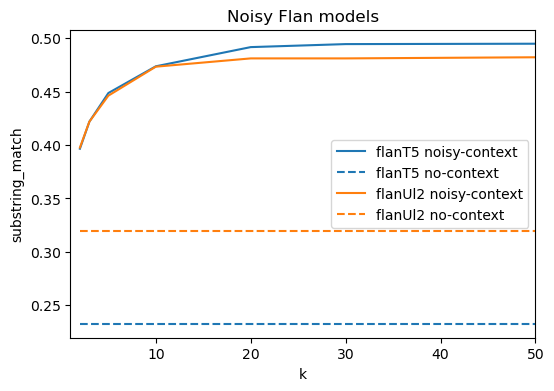

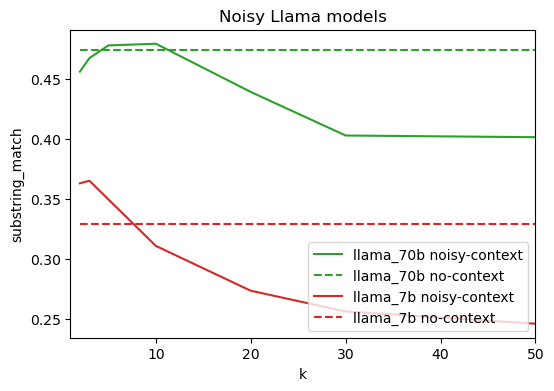

In [57]:
# for those with no gold par found, what is the baseline performance?

linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
# plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'nq'
reader_metric = 'substring_match'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
noisy_output_dfs = noisy_output_by_dataset[dataset]

readers_perf = {}
for r, reader_model in enumerate(reader_models):
    readers_perf[reader_model] = {}
    if 'truncation' in reader_model:
        continue
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        readers_perf[reader_model][top_k] = {}
        k_df = noisy_output_dfs[reader_model][retriever][top_k]
        # slice = k_df
        # slice = k_df[f'answer_in_context'] == False
        slice_df = k_df
        baseline_df = output_dfs[reader_model]['no_context']
        # baseline_df = baseline_df.loc[slice]
        readers_perf[reader_model][top_k][reader_metric] = np.mean(slice_df[reader_metric].values)
        readers_perf[reader_model][top_k][f'baseline {reader_metric}'] = np.mean(baseline_df[reader_metric].values)
plt.figure(figsize = (6,4))
for i, (r, top_kdict) in enumerate(readers_perf.items()):
    if 'truncation' in r:
        continue
    top_k_f1s = []
    baseline_f1s = []
    ks = []
    for top_k, value_dict in top_kdict.items():
        ks.append((int)(top_k[3:]))
        top_k_f1s.append(value_dict[reader_metric])
        baseline_f1s.append(value_dict[f'baseline {reader_metric}'])
    if '7b' in r:
        color = colors[3]
    elif '70b' in r:
        color = colors[2]
    else:
        color = colors[i%len(reader_models)]
        
    plt.plot(ks, top_k_f1s, color = color, label = f'{r} noisy-context')
    plt.plot(ks, baseline_f1s, color = color, linestyle = '--', label = f'{r} no-context')
    if r == 'flanUl2':
        plt.title(f'Noisy Flan models')
        plt.legend()
        
        plt.ylim(bottom = 0.1, top = 0.4)
        plt.xlim(left = 1, right = 50)
        plt.xlabel('k')
        plt.ylabel(reader_metric)
        plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_noisy_{reader_metric}.pdf'),bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.figure(figsize = (6,4))
        
  
plt.title(f'Noisy Llama models')
plt.legend()
plt.ylim(bottom = 0.1, top = 0.4)
plt.xlim(left = 1, right = 50)
plt.xlabel('k')
plt.ylabel(reader_metric)
plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_noisy_{reader_metric}.pdf'),bbox_inches='tight', pad_inches=0)
plt.show()

flanT5 0.1368475471222495
flanUl2 0.13574385185291465


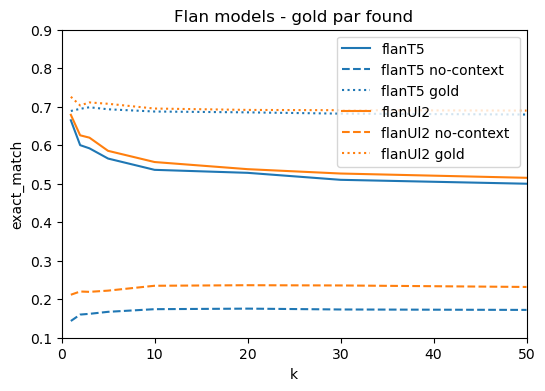

llama_70b 0.1957086150183681
llama_7b 0.21738120712327702


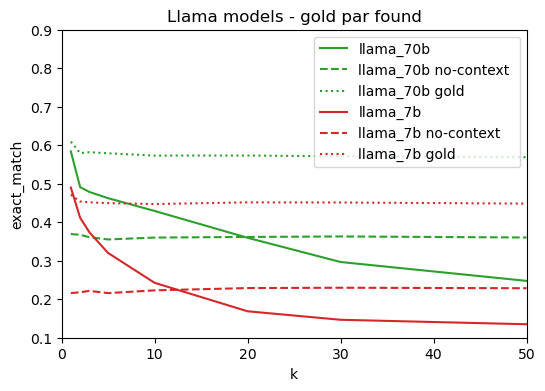

In [74]:
# for those with no gold par found, what is the baseline performance?

linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
# plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'nq'
reader_metric = 'exact_match'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]


readers_perf = {}
for r, reader_model in enumerate(reader_models):
    readers_perf[reader_model] = {}
    if 'truncation' in reader_model:
        continue
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        readers_perf[reader_model][top_k] = {}
        k_df =output_dfs[reader_model][retriever][top_k]
        slice = k_df[f'any {docid_name}_{section_name}_id_match'] == True
        # slice = k_df[f'answer_in_context'] == False
        slice_df = k_df.loc[slice]
        baseline_df = output_dfs[reader_model]['no_context']
        baseline_df = baseline_df.loc[slice]
        readers_perf[reader_model][top_k][reader_metric] = np.mean(slice_df[reader_metric].values)
        readers_perf[reader_model][top_k][f'no_context {reader_metric}'] = np.mean(baseline_df[reader_metric].values)
        baseline_df = output_dfs[reader_model]['gold']
        baseline_df = baseline_df.loc[slice]
        readers_perf[reader_model][top_k]['gold {reader_metric}'] = np.mean(baseline_df[reader_metric].values)
        
plt.figure(figsize = (6,4))
for i, (r, top_kdict) in enumerate(readers_perf.items()):
    if 'truncation' in r:
        continue
    top_k_f1s = []
    no_context_f1s = []
    gold_f1s = []
    ks = []
    for top_k, value_dict in top_kdict.items():
        ks.append((int)(top_k[3:]))
        top_k_f1s.append(value_dict[reader_metric])
        no_context_f1s.append(value_dict[f'no_context {reader_metric}'])
        gold_f1s.append(value_dict['gold {reader_metric}'])
    
    if '7b' in r:
        color = colors[3]
    elif '70b' in r:
        color = colors[2]
    else:
        color = colors[i%len(reader_models)]
    plt.plot(ks, top_k_f1s, color = color, label = f'{r}')
    plt.plot(ks, no_context_f1s, color = color, linestyle = '--', label = f'{r} no-context ')
    plt.plot(ks, gold_f1s, color = color, linestyle = ':', label = f'{r} gold')
    diff = 0
    for z in [0,4,5,6,7]:
        diff += gold_f1s[z]-top_k_f1s[z]
    diff/= 5
    print(r, diff)
    
    if r == 'flanUl2':
        plt.title(f'Flan models - gold par found')
        plt.legend()
        
        plt.ylim(bottom = 0.1, top = 0.9)
        plt.xlim(left = 0, right = 50)
        plt.xlabel('k')
        plt.ylabel(reader_metric)
        # plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_flan_gold_par_found_{reader_metric}.pdf'),bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.figure(figsize = (6,4))
  
plt.title(f'Llama models - gold par found')
plt.legend()
plt.ylim(bottom = 0.1, top = 0.9)
plt.xlim(left = 0, right = 50)
plt.xlabel('k')
plt.ylabel(reader_metric)
# plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_llama_gold_par_found_{reader_metric}.pdf'),bbox_inches='tight', pad_inches=0)
plt.show()
    

flanT5 0.07520656337143018
flanUl2 0.09890680695668623


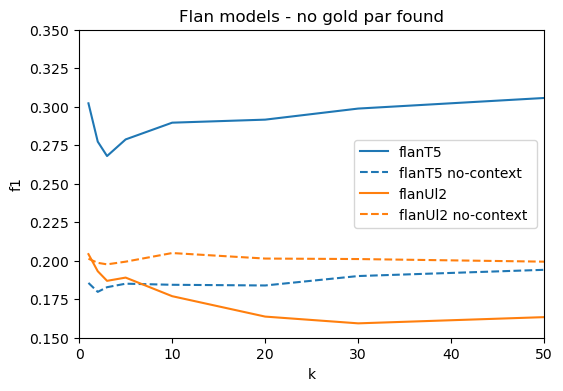

llama_70b 0.11534663990400604
llama_7b 0.06496934741082772


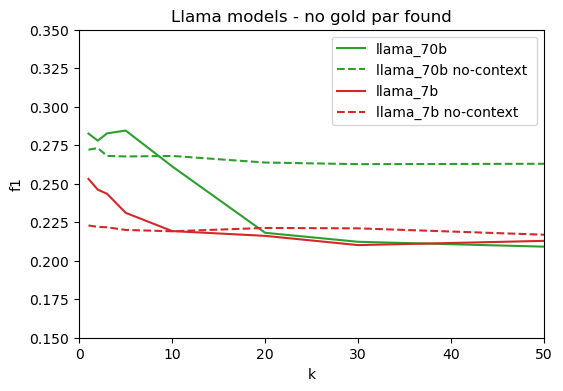

In [102]:
# for those with no gold par found, what is the baseline performance?

linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
# plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'complete_bioasq'
reader_metric = 'f1'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]


readers_perf = {}
for r, reader_model in enumerate(reader_models):
    readers_perf[reader_model] = {}
    # if 'truncation' in reader_model:
    #     continue
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        readers_perf[reader_model][top_k] = {}
        k_df =output_dfs[reader_model][retriever][top_k]
        slice = (k_df[f'any {docid_name}_{section_name}_id_match'] == False)
        # slice = k_df[f'answer_in_context'] == False
        slice_df = k_df.loc[slice]
        baseline_df = output_dfs[reader_model]['no_context']
        baseline_df = baseline_df.loc[slice]
        readers_perf[reader_model][top_k]['f1'] = np.mean(slice_df['f1'].values)
        readers_perf[reader_model][top_k]['no_context f1'] = np.mean(baseline_df['f1'].values)
        baseline_df = output_dfs[reader_model]['gold']
        baseline_df = baseline_df.loc[slice]
        readers_perf[reader_model][top_k]['gold f1'] = np.mean(baseline_df['f1'].values)
        
plt.figure(figsize = (6,4))
for i, (r, top_kdict) in enumerate(readers_perf.items()):
    if 'truncation' in r:
        continue
    top_k_f1s = []
    no_context_f1s = []
    gold_f1s = []
    ks = []
    for top_k, value_dict in top_kdict.items():
        ks.append((int)(top_k[3:]))
        top_k_f1s.append(value_dict['f1'])
        no_context_f1s.append(value_dict['no_context f1'])
        gold_f1s.append(value_dict['gold f1'])
    if '7b' in r:
        color = colors[3]
    elif '70b' in r:
        color = colors[2]
    else:
        color = colors[i%len(reader_models)]
    plt.plot(ks, top_k_f1s, color = color, label = f'{r}')
    plt.plot(ks, no_context_f1s, color = color, linestyle = '--', label = f'{r} no-context ')
    # plt.plot(ks, gold_f1s, color = colors[i], linestyle = ':', label = f'{r} gold')
    diff = 0
    for z in [0,4,5,6,7]:
        diff += gold_f1s[z]-top_k_f1s[z]
    diff/= 5
    print(r, diff)
    
    if r == 'flanUl2':
        plt.title(f'Flan models - no gold par found')
        plt.legend()
        
        plt.ylim(bottom = 0.15, top = 0.35)
        plt.xlim(left = 0, right = 50)
        plt.xlabel('k')
        plt.ylabel('f1')
        plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_flan_no_gold_par_found.pdf'),bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.figure(figsize = (6,4))
  
plt.title(f'Llama models - no gold par found')
plt.legend()
plt.ylim(bottom = 0.15, top = 0.35)
plt.xlim(left = 0, right = 50)
plt.xlabel('k')
plt.ylabel('f1')
plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_llama_no_gold_par_found.pdf'),bbox_inches='tight', pad_inches=0)
plt.show()
    

# 2c. Plot baseline performances

flanT5
gold 0.7954697266527507
no_context 0.24010735290784338

flanUl2
gold 0.8019702883604333
no_context 0.3159856858143572

llama_70b
gold 0.704459189088155
no_context 0.46789306505526174

llama_70b_2000_truncation
llama_7b
gold 0.58763692553026
no_context 0.3235990825192028

llama_7b_2000_truncation


<Figure size 700x500 with 0 Axes>

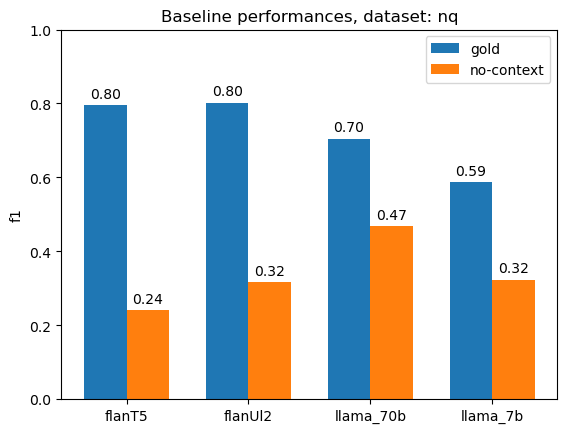

In [51]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'nq'
reader_metric = 'f1'
group1 = []
group2 = []
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    print(reader_model)
    if 'truncation' in reader_model:
        continue
    for i, baseline in enumerate(['gold', 'no_context']):
        k_df =output_dfs[reader_model][baseline]
        slice_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(slice_df[reader_metric].values) # CAN CHANGE READER METRIC HERE
        print(baseline, reader_perf)
        if baseline == 'gold':
            group1.append(reader_perf)
        else:
            group2.append(reader_perf)
    print()

import matplotlib.pyplot as plt
import numpy as np

r2 = reader_models.copy()
for r in r2:
    if 'truncation' in r:
        r2.remove(r)

n_models = len(r2)

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(r2))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, group1, width, label='gold')
rects2 = ax.bar(x + width/2, group2, width, label='no-context')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(reader_metric)
ax.set_title(f'Baseline performances, dataset: {dataset}')
ax.set_xticks(x)
ax.set_xticklabels(r2)
ax.legend()
ax.set_ylim(bottom= 0, top = 1.0)

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.savefig(f'/data/tir/projects/tir6/general/afreens/dbqa/figs/{dataset}_baselines_{reader_metric}.pdf', bbox_inches='tight', pad_inches=0)
plt.show()



flanT5
gold 0.8286922805780754
no_context 0.23264011279520622

flanUl2
gold 0.8371519210433557
no_context 0.31970391258371517

llama_70b
gold 0.7448008459640465
no_context 0.47444483609446597

llama_70b_2000_truncation
llama_7b
gold 0.6316531547409235
no_context 0.32886852308776876

llama_7b_2000_truncation


<Figure size 700x500 with 0 Axes>

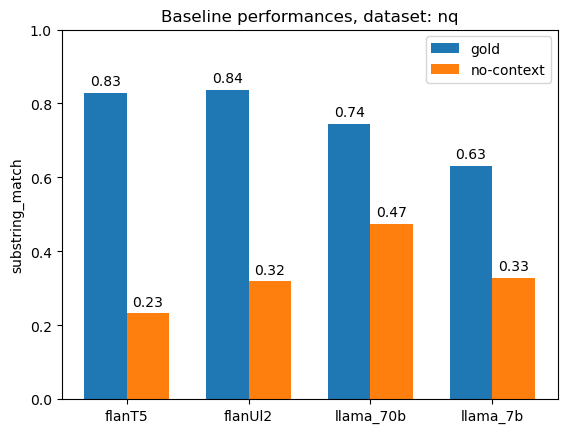

In [50]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'nq'
reader_metric = 'substring_match'
group1 = []
group2 = []
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    print(reader_model)
    if 'truncation' in reader_model:
        continue
    for i, baseline in enumerate(['gold', 'no_context']):
        k_df =output_dfs[reader_model][baseline]
        slice_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(slice_df[reader_metric].values) # CAN CHANGE READER METRIC HERE
        print(baseline, reader_perf)
        if baseline == 'gold':
            group1.append(reader_perf)
        else:
            group2.append(reader_perf)
    print()

import matplotlib.pyplot as plt
import numpy as np

r2 = reader_models.copy()
for r in r2:
    if 'truncation' in r:
        r2.remove(r)

n_models = len(r2)

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(r2))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, group1, width, label='gold')
rects2 = ax.bar(x + width/2, group2, width, label='no-context')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(reader_metric)
ax.set_title(f'Baseline performances, dataset: {dataset}')
ax.set_xticks(x)
ax.set_xticklabels(r2)
ax.legend()
ax.set_ylim(bottom= 0, top = 1.0)

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.savefig(f'/data/tir/projects/tir6/general/afreens/dbqa/figs/{dataset}_baselines_{reader_metric}.pdf', bbox_inches='tight', pad_inches=0)
plt.show()



flanT5
gold 0.673598872047938
no_context 0.1663729291505111

flanUl2
gold 0.6813535424744448
no_context 0.23545999295029962

llama_70b
gold 0.5576313006697216
no_context 0.3387381036305957

llama_70b_2000_truncation
llama_7b
gold 0.43637645400070496
no_context 0.213253436728939

llama_7b_2000_truncation


<Figure size 700x500 with 0 Axes>

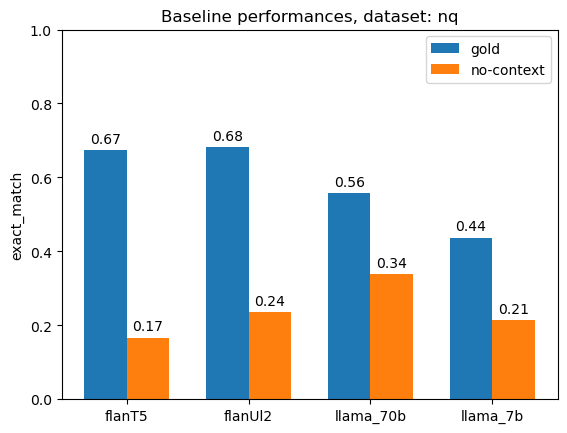

In [49]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'nq'
reader_metric = 'exact_match'
group1 = []
group2 = []
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    print(reader_model)
    if 'truncation' in reader_model:
        continue
    for i, baseline in enumerate(['gold', 'no_context']):
        k_df =output_dfs[reader_model][baseline]
        slice_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(slice_df[reader_metric].values) # CAN CHANGE READER METRIC HERE
        print(baseline, reader_perf)
        if baseline == 'gold':
            group1.append(reader_perf)
        else:
            group2.append(reader_perf)
    print()

import matplotlib.pyplot as plt
import numpy as np

r2 = reader_models.copy()
for r in r2:
    if 'truncation' in r:
        r2.remove(r)

n_models = len(r2)

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(r2))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, group1, width, label='gold')
rects2 = ax.bar(x + width/2, group2, width, label='no-context')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(reader_metric)
ax.set_title(f'Baseline performances, dataset: {dataset}')
ax.set_xticks(x)
ax.set_xticklabels(r2)
ax.legend()
ax.set_ylim(bottom= 0, top = 1.0)

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.savefig(f'/data/tir/projects/tir6/general/afreens/dbqa/figs/{dataset}_baselines_{reader_metric}.pdf', bbox_inches='tight', pad_inches=0)
plt.show()



flanT5
gold 0.4009976786138374
no_context 0.1823990275354657

flanUl2
gold 0.29821640788266984
no_context 0.19179929188453648

llama_70b
gold 0.37046164537367593
no_context 0.25948211696673446

llama_7b
gold 0.3110356349084336
no_context 0.2111593585727717



<Figure size 700x500 with 0 Axes>

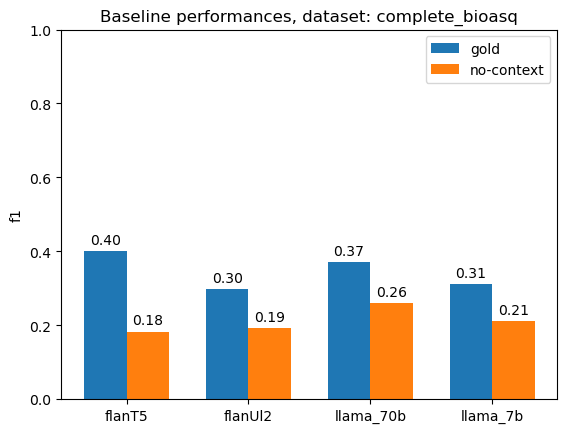

[0.21859865 0.10641712 0.11097953 0.09987628]
0.16250788353825252 0.10542790237130169


In [9]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'complete_bioasq'
group1 = []
group2 = []
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    print(reader_model)
    if 'truncation' in reader_model:
        continue
    for i, baseline in enumerate(['gold', 'no_context']):
        k_df =output_dfs[reader_model][baseline]
        slice_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(slice_df['f1'].values) # CAN CHANGE READER METRIC HERE
        print(baseline, reader_perf)
        if baseline == 'gold':
            group1.append(reader_perf)
        else:
            group2.append(reader_perf)
    print()

import matplotlib.pyplot as plt
import numpy as np
r2 = reader_models.copy()
for r in r2:
    if 'truncation' in r:
        r2.remove(r)

n_models = len(r2)

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(r2))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, group1, width, label='gold')
rects2 = ax.bar(x + width/2, group2, width, label='no-context')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('f1')
ax.set_title(f'Baseline performances, dataset: {dataset}')
ax.set_xticks(x)
ax.set_xticklabels(r2)
ax.legend()
ax.set_ylim(bottom= 0, top = 1.0)

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.savefig(f'/data/tir/projects/tir6/general/afreens/dbqa/figs/{dataset}_baselines.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

diffs = np.array(group1) - np.array(group2)
print(diffs)
print(np.mean(diffs[:2]), np.mean(diffs[2:]))



flanT5
gold 0.43732082356007296
no_context 0.19989575188949701

flanUl2
gold 0.3557466770914777
no_context 0.23064894448788115

llama_70b
gold 0.5496481626270524
no_context 0.44513943184779775

llama_70b_2000_truncation
llama_7b
gold 0.4615585092520198
no_context 0.3630440448266875

llama_7b_2000_truncation


<Figure size 700x500 with 0 Axes>

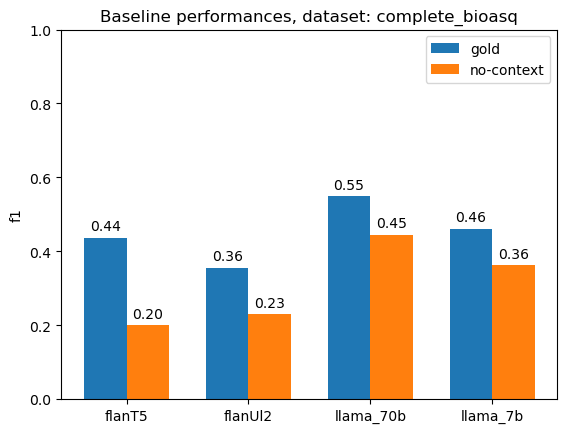

[0.23742507 0.12509773 0.10450873 0.09851446]
0.18126140213708625 0.10151159760229347


In [89]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'complete_bioasq'
group1 = []
group2 = []
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]
for r, reader_model in enumerate(reader_models):
    print(reader_model)
    if 'truncation' in reader_model:
        continue
    for i, baseline in enumerate(['gold', 'no_context']):
        k_df =output_dfs[reader_model][baseline]
        slice_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(slice_df['substring_match'].values) # CAN CHANGE READER METRIC HERE
        print(baseline, reader_perf)
        if baseline == 'gold':
            group1.append(reader_perf)
        else:
            group2.append(reader_perf)
    print()

import matplotlib.pyplot as plt
import numpy as np
r2 = reader_models.copy()
for r in r2:
    if 'truncation' in r:
        r2.remove(r)

n_models = len(r2)

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(r2))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, group1, width, label='gold')
rects2 = ax.bar(x + width/2, group2, width, label='no-context')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('f1')
ax.set_title(f'Baseline performances, dataset: {dataset}')
ax.set_xticks(x)
ax.set_xticklabels(r2)
ax.legend()
ax.set_ylim(bottom= 0, top = 1.0)

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
# plt.savefig(f'/data/tir/projects/tir6/general/afreens/dbqa/figs/{dataset}_baselines.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

diffs = np.array(group1) - np.array(group2)
print(diffs)
print(np.mean(diffs[:2]), np.mean(diffs[2:]))



# 2d Plot by slice - Question Category
Change question_category, dataset, or reader_metric as you see fit

flanT5 colbert
flanUl2 colbert
llama_70b colbert
llama_7b colbert


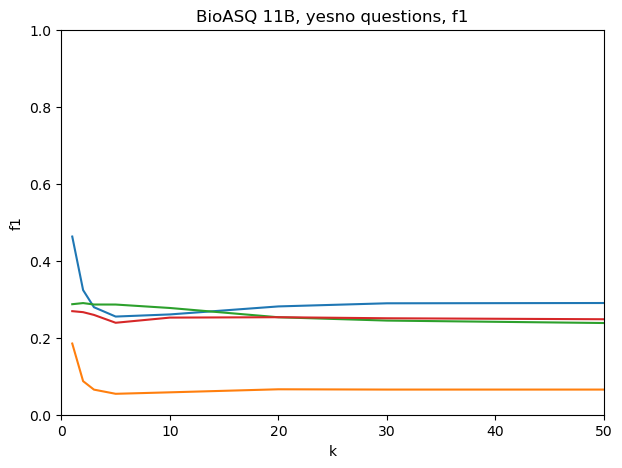

In [ ]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
reader_models.sort()
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]

plt.figure(figsize=(7, 5))
reader_models.sort()

dataset = 'complete_bioasq'
output_dfs = output_by_dataset[dataset]

reader_metric = 'f1'
question_category = 'yesno'
for r, reader_model in enumerate(reader_models):
    if 'truncation' in reader_model:
        continue
    for r2, retriever_model in enumerate(['colbert']):
        print(reader_model, retriever_model)
        reader_perf_by_k = []
        for i, top_k in enumerate(top_ks[1:]):
            k_df =output_dfs[reader_model][retriever_model][top_k]
            k_df = k_df.loc[k_df['question_category'] == question_category]
            slice_df = k_df# CAN CHANGE SLICE CONDITION HERE
            reader_perf_by_k.append(np.mean(slice_df[reader_metric].values)) # CAN CHANGE READER METRIC HERE
        if '7b' in reader_model:
            color = colors[3]
        elif '70b' in reader_model:
            color = colors[2]
        else:
            color = colors[r%len(reader_models)]
        plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = f'{reader_model}', color = color, linestyle = linestyles[r2])

plt.title(f'BioASQ 11B, {question_category} questions, {reader_metric}')

plt.xlabel('k')
plt.ylabel(reader_metric)
plt.ylim(top = 1.0, bottom = 0.0)
plt.xlim(left = 0, right = 50)
# plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# plt.savefig(os.path.join('/data/tir/projects/tir6/general/afreens/dbqa/figs', f'{dataset}_{reader_metric}_{question_category}.pdf') , bbox_inches='tight', pad_inches=0)
plt.show()

# 2e Plot reader_metric by precision

flanT5 0.14350997442188396
flanUl2 0.18299739123635583
llama_70b 0.2965737778472626
llama_7b 0.40131992363082986
/data/tir/projects/tir6/general/afreens/dbqa/figs/f1_by_prec_nq.pdf


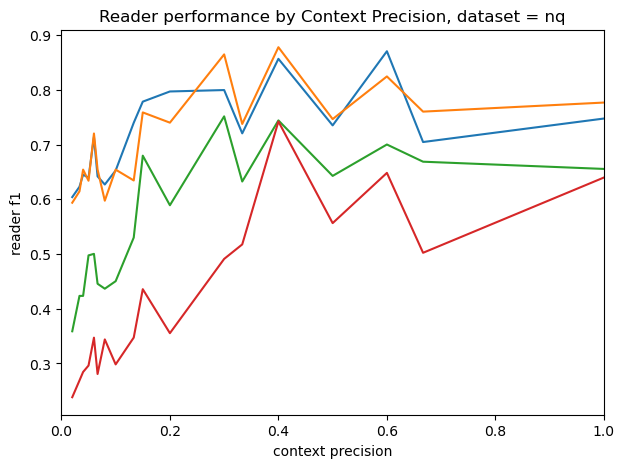

In [ ]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
reader_models.sort()
dataset = 'nq'
reader_metric = 'f1'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'
output_dfs = output_by_dataset[dataset]


for r, reader_model in enumerate(reader_models):
    readers_perf[reader_model] = {}
    if 'truncation' in reader_model:
        continue
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        readers_perf[reader_model][top_k] = {}
        k_df =output_dfs[reader_model][retriever][top_k]
        slice_df = k_df.loc[k_df[f'any {docid_name}_{section_name}_id_match'] == True]
        slice_df = k_df
        readers_perf[reader_model][top_k]['precision'] = slice_df[f'precision {docid_name}_{section_name}_id_match'].values
        readers_perf[reader_model][top_k]['f1'] = slice_df['f1'].values


for j, r in enumerate(reader_models):
    if 'truncation' in r:
            continue
    f1_by_prec = {}
    for top_k in top_ks[1:]:
        k = (int)(top_k[3:])
        
        for i in range(0,k+1):
            
            slice = np.where(readers_perf[r][top_k]['precision'] == i/k)
            if (len(slice[0]) != 0):
                if i/k not in f1_by_prec:
                    f1_by_prec[i/k] = [np.mean(readers_perf[r][top_k]['f1'][slice])]
                else:
                    f1_by_prec[i/k].append(np.mean(readers_perf[r][top_k]['f1'][slice]))
    f1_mean_by_prec = {}
    for k in sorted(f1_by_prec.keys()):
        # if k == 0.0:
        #     continue
        f1_mean_by_prec[k] = np.mean(f1_by_prec[k])
    x = np.array(list(f1_mean_by_prec.keys()))
    y = np.array(list(f1_mean_by_prec.values()))

    print(r, (list(f1_mean_by_prec.values())[-1] - list(f1_mean_by_prec.values())[1]))
    if '7b' in r:
        color = colors[3]
    elif '70b' in r:
        color = colors[2]
    else:
        color = colors[j%len(reader_models)]
    plt.plot(list(f1_mean_by_prec.keys())[1:], list(f1_mean_by_prec.values())[1:], '-', label = r, color = color)

plt.xlabel('context precision')
plt.ylabel('reader f1')
plt.xlim(left = 0, right = 1.0)
plt.title(f'Reader performance by Context Precision, dataset = {dataset}')
# plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'f1_by_prec_{dataset}.pdf') , bbox_inches='tight', pad_inches=0)
print(os.path.join(os.getenv('DBQA'), 'figs', f'f1_by_prec_{dataset}.pdf'))
plt.show()
